In [1]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

In [2]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        if not os.path.isfile(filepath):
            utils.download_url(URL + filename, dataset_location, filename, None)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [3]:
train_loader, valid_loader, test_loader = get_data_loader("binarized_mnist", 64)

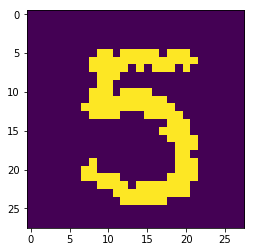

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in train_loader:
    plt.imshow(x[0, 0])
    break

In [70]:
import vae  # needed to allow the reload
import importlib
importlib.reload(vae)  # forces a reloading of the module (because jupyter notebook will not reload it after it has been modified)
from vae import VAE
from torch import optim

device = torch.device("cuda")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)


def ELBO_loss_function(recon_x, x, mu, logvar):
    # ELBO: L(θ, φ; x) = -E_z~q_φ[log p_θ(x|z)] + D_KL(q_φ(z|x)||p(z))
    # reconstruction loss + regularizer (forcing the encoder's output to stay close to a standard Normal distribution)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    batch_size = x.shape[0]
    
    return (BCE + KLD) / batch_size


def train_vae(epoch, train_loader):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = ELBO_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader)))

    
def test_vae(epoch, test_loader):
    model.eval()
    nb_examples = 0
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            batch_size = data.shape[0]
            recon_batch, mu, logvar = model(data)
            test_loss += ELBO_loss_function(recon_batch, data, mu, logvar).item() * batch_size
            nb_examples += batch_size
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n], recon_batch.view(64, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= nb_examples
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [71]:
for epoch in range(20):
    train_vae(epoch, train_loader)
    test_vae(epoch, valid_loader)

Train Epoch: 0 [0/50000 (0%)]	Loss: 549.177673
Train Epoch: 0 [6400/50000 (13%)]	Loss: 221.149353
Train Epoch: 0 [12800/50000 (26%)]	Loss: 184.490433
Train Epoch: 0 [19200/50000 (38%)]	Loss: 164.763855
Train Epoch: 0 [25600/50000 (51%)]	Loss: 165.892441
Train Epoch: 0 [32000/50000 (64%)]	Loss: 146.071671
Train Epoch: 0 [38400/50000 (77%)]	Loss: 147.616241
Train Epoch: 0 [44800/50000 (90%)]	Loss: 137.116226
====> Epoch: 0 Average loss: 180.8418
====> Test set loss: 137.2409
Train Epoch: 1 [0/50000 (0%)]	Loss: 141.433823
Train Epoch: 1 [6400/50000 (13%)]	Loss: 136.259674
Train Epoch: 1 [12800/50000 (26%)]	Loss: 134.421616
Train Epoch: 1 [19200/50000 (38%)]	Loss: 137.932571
Train Epoch: 1 [25600/50000 (51%)]	Loss: 123.571335
Train Epoch: 1 [32000/50000 (64%)]	Loss: 127.106209
Train Epoch: 1 [38400/50000 (77%)]	Loss: 116.417206
Train Epoch: 1 [44800/50000 (90%)]	Loss: 122.746544
====> Epoch: 1 Average loss: 125.6401
====> Test set loss: 117.0890
Train Epoch: 2 [0/50000 (0%)]	Loss: 117.5772

Train Epoch: 17 [12800/50000 (26%)]	Loss: 102.144516
Train Epoch: 17 [19200/50000 (38%)]	Loss: 93.785812
Train Epoch: 17 [25600/50000 (51%)]	Loss: 95.418083
Train Epoch: 17 [32000/50000 (64%)]	Loss: 91.882706
Train Epoch: 17 [38400/50000 (77%)]	Loss: 94.817940
Train Epoch: 17 [44800/50000 (90%)]	Loss: 91.646324
====> Epoch: 17 Average loss: 94.2574
====> Test set loss: 94.8378
Train Epoch: 18 [0/50000 (0%)]	Loss: 96.356934
Train Epoch: 18 [6400/50000 (13%)]	Loss: 92.918198
Train Epoch: 18 [12800/50000 (26%)]	Loss: 92.706802
Train Epoch: 18 [19200/50000 (38%)]	Loss: 100.813385
Train Epoch: 18 [25600/50000 (51%)]	Loss: 96.421371
Train Epoch: 18 [32000/50000 (64%)]	Loss: 97.982330
Train Epoch: 18 [38400/50000 (77%)]	Loss: 101.981293
Train Epoch: 18 [44800/50000 (90%)]	Loss: 93.683815
====> Epoch: 18 Average loss: 94.0198
====> Test set loss: 94.5863
Train Epoch: 19 [0/50000 (0%)]	Loss: 93.741051
Train Epoch: 19 [6400/50000 (13%)]	Loss: 90.401367
Train Epoch: 19 [12800/50000 (26%)]	Loss: 9

In [72]:
torch.save(model.state_dict(), 'vae_elbo.pt')

In [96]:
# x has shape (M, D)
# z has shape (M, K, D)
# Where M is mini-batch size, D is the dimension of the input and K is importance sampling count
def importance_sampling_loss_function(model, x, z):
    # log sum_k exp (log p(x|z) + log p(z) - log q(z|x)) - log k
    losses = []
    K = z.shape[1]
    log_k = np.log(K)
    for x_i, z_i in zip(x, z):
        mu, logvar = model.encode(x)
        sum_k = 0
        for z_ik in z_i:
            log_pxz = torch.log(model.decode(z_ik))
            log_pz = torch.log(gaussian_sample_probability(z_ik, 0, 1))
            log_qzx = torch.log(gaussian_sample_probability(z_ik, mu, logvar))
            sum_k += torch.exp(log_pxz + log_pz - log_qzx)
        L = torch.log(sum_k) - log_k
        losses.append(L)
    return losses
    

def gaussian_sample_probabity(z, mu, logvar):
    var = torch.exp(logvar)
    coef = 1 / torch.sqrt(2 * torch.np.math.pi * var)
    exponential = torch.exp(-(z - mu).pow(2) / 2 * var)
    return exponential * coef


def evaluate_loglikelihood(model, x, K=200):
    mu, logvar = model.encode(x)
    mu = torch.unsqueeze(mu, 1)
    mu = mu.repeat(1, K, 1)
    std = torch.exp(0.5 * logvar)
    std = torch.unsqueeze(std, 1)
    std = std.repeat(1, K, 1)
    eps = torch.randn_like(std)
    print("mu", mu.size())
    print("eps", eps.size())
    print("std", std.size())
    z = mu + eps * std
    losses = importance_sampling_loss_function(model, x, z)
    return losses.mean()

for i, data in enumerate(test_loader):
    data = data.to(device)
    loglikelihood = evaluate_loglikelihood(model, data)
    print(loglikelihood)

mu torch.Size([64, 200, 100])
eps torch.Size([64, 200, 100])
std torch.Size([64, 200, 100])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 256, 5, 5], but got 3-dimensional input of size [256, 1, 1] instead